<a href="https://www.kaggle.com/code/milicaradisavljevic/waste-classification-vgg16?scriptVersionId=185538092" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import libraries

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing


# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import vgg16
from tensorflow.keras import optimizers
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array


2024-06-26 09:48:59.419781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 09:48:59.419885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 09:48:59.547115: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
for dirname, _, _ in os.walk('/kaggle/input'):
        print(dirname)

/kaggle/input
/kaggle/input/waste-classification-data
/kaggle/input/waste-classification-data/DATASET
/kaggle/input/waste-classification-data/DATASET/TEST
/kaggle/input/waste-classification-data/DATASET/TEST/R
/kaggle/input/waste-classification-data/DATASET/TEST/O
/kaggle/input/waste-classification-data/DATASET/TRAIN
/kaggle/input/waste-classification-data/DATASET/TRAIN/R
/kaggle/input/waste-classification-data/DATASET/TRAIN/O
/kaggle/input/waste-classification-data/dataset
/kaggle/input/waste-classification-data/dataset/DATASET
/kaggle/input/waste-classification-data/dataset/DATASET/TEST
/kaggle/input/waste-classification-data/dataset/DATASET/TEST/R
/kaggle/input/waste-classification-data/dataset/DATASET/TEST/O
/kaggle/input/waste-classification-data/dataset/DATASET/TRAIN
/kaggle/input/waste-classification-data/dataset/DATASET/TRAIN/R
/kaggle/input/waste-classification-data/dataset/DATASET/TRAIN/O


# About the data

Waste means any item excluded from further use. It can come from our homes, like food scraps and packaging, or from businesses and factories, like leftover materials and byproducts. Inadequate waste management represents one of the biggest problems from the aspect of environmental protection. When waste is not properly managed, it often ends up in landfills, where it can leach harmful chemicals into the soil and groundwater. Poor waste management also contributes to pollution, as plastics and other materials can end up in oceans and other natural habitats, harming wildlife. Additionally, the improper disposal of waste can lead to the release of toxic substances into the air, exacerbating air pollution and contributing to climate change. Effective waste management is crucial to minimizing these environmental impacts and protecting public health.

Dataset is divided into train data (85%) and test data (15%). Segregated into two classes (Organic and recyclable).
- Training data - 22564 images;
- Test data - 2513 images.


# Objectives

We will train a model to classify the waste in the images as organic or recyclable. Main idea is to implement Transfer Learning: utilize VGG-16, a pre-trained convolutional neural network (CNN), as the base model. By transfer learning we means using pre-trained models, fine-tuning them on new data, and adapting their learned features to new tasks, thereby accelerating learning and improving model performance.

- Import data from Kaggle;
- Model configuration;
- Image augmentation;
- Vizualization few images from training data;
- Adding VGG-16 base model;
- Training model;
- Evaluate the model's performance by running it on the test set.

# Model configuration options

In [3]:
#image dimensions and batch size
img_rows, img_cols = 224, 224 #specify width and height of the images
batch_size = 64

#training parameters
n_epochs = 5 
n_classes = 2 
validation_split = 0.2 #20% of the data for validation
verbosity = 1 #We want to be able to see the model output, verbosity=1 or True

#path specifies the location where train data is stored
path = "/kaggle/input/waste-classification-data/DATASET/TRAIN/"
#path_test specifies the location where test data is stored
path_test = "/kaggle/input/waste-classification-data/DATASET/TEST/"

#image input shape (w, h, d)
input_shape = (img_rows, img_cols, 3) #RGB

#organic (O) and recyclable (R) labels
labels = ['O', 'R']

#value of 10 for random number generation in Python environment
seed = 10

# Image Augmentation

ImageDataGenerator in Keras is used to preprocess and augment image data for training deep learning models by applying various transformations such as scaling, rotation, flipping, and zooming.

- validation_split - % of the data for validation;
- rescale=1.0/255 - Scale the image pixel values to the range of [0, 1];
- width_shift_range - Randomly shifts the width of the images by up to % of the total width; This augmentation technique helps the model generalize better by introducing variations in the position of objects within the images.
- height_shift_range - Randomly shifts the width of the images by up to % of the total height;
- Horizontal_flip - randomply flip inputs horizontally. This augmentation technique is useful for training models that need to recognize objects irrespective of their orientation.

In [4]:
train_datagen = ImageDataGenerator(
    validation_split = validation_split,
    rescale=1.0/255.0, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip = True,
)

validation_datagen = ImageDataGenerator(
    validation_split = validation_split,
    rescale=1.0/255.0,
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

"flow_from_directory" allows us to load batches of images from a directory on disk, applying specified data augmentation techniques in real-time during model training.

- directory: Specifies the path to the target directory containing the images;
- classes: Optional parameter that specifies the list of class subdirectories to consider within the directory;
- seed: Sets the seed for the random number generator. This ensures reproducibility in data augmentation and shuffling;
- batch_size: Specifies the size of the batches of data (number of images) that the generator yields during each iteration;
- class_mode: Specifies the type of label arrays returned by the generator. 

1. 'binary': For binary classification tasks (e.g., cats vs dogs).
2. 'categorical': For multi-class classification tasks with one-hot encoded labels.
3. 'sparse': For multi-class classification tasks with integer labels.
4. 'input': Returns the images without any labels, useful for model prediction on new data.

- shuffle: Determines whether to shuffle the data order. Shuffling helps in reducing bias during training by presenting the data in random order;
- target_size: Specifies the dimensions to which all images found will be resized;
- subset: Specifies whether this generator will generate data for the 'training' or 'validation' subset of the dataset. 

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'training'
)

validation_generator = validation_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    classes = labels,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows)
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


We have 18052 images with 2 classes in the training set, 4512 in the validation set, and 2513 in the test set.

# Visualization

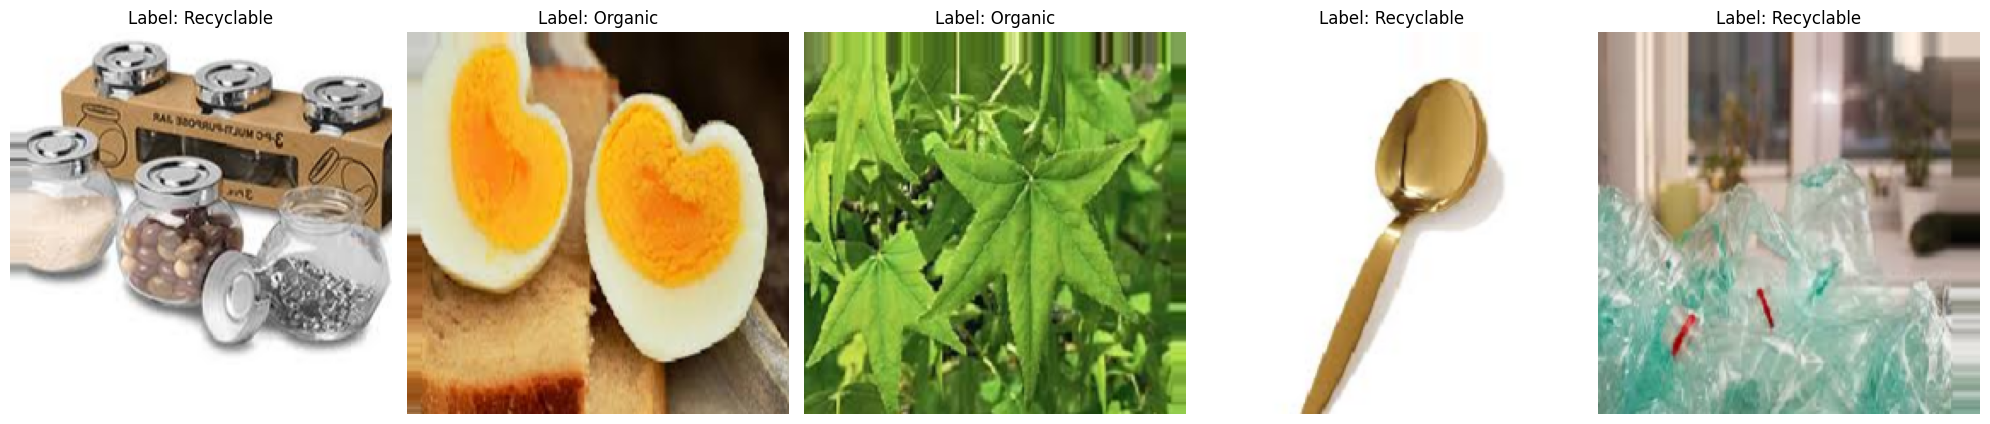

In [6]:
# Generate 5 random indexes to select images from the train_generator
random_indices = np.random.randint(len(train_generator), size=5)

# Plot the images and print their labels
plt.figure(figsize=(20, 10))
for i, rand_idx in enumerate(random_indices):
    batch = train_generator[rand_idx]
    images = batch[0]  # Get the batch of images
    labels = batch[1]  # Get the batch of labels
    
    for j in range(batch_size):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[j])
        plt.title('Label: {}'.format('Organic' if labels[j] == 0 else 'Recyclable'))
        plt.axis('off')
        break  # Only plot one image per batch (assuming batch_size > 1)

plt.tight_layout()
plt.show()

# Model

## Base model

The most commonly used dataset for pretraining is ImageNet. ImageNet is a large dataset of images collected from the web that has been widely used for training and benchmarking computer vision models, particularly in the field of deep learning.

Pre-trained models are networks that have previously been trained on some large datasets. These models form the basis of transfer learning. In computer vision, some popular pre-trained models include: VGG-16, VGG-19, InceptionV3, XCeption, and ResNet-50. 

In this model we will use **VGG-16**. 

The default input image size for VGG-16 is 224x224 pixels.

- include_top: Setting include_top=False means that only the convolutional base of the VGG-16 model will be loaded, excluding the fully connected layers at the top;

- weights: Indicates that the pre-trained weights of the VGG-16 model trained on the ImageNet dataset will be used;

- input_shape: (img_rows, img_cols, RGB).

In [7]:
from keras.applications import vgg16

vgg=vgg16.VGG16(weights='imagenet', 
                        include_top=False, 
                        input_shape=(224,224,3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [8]:
#accesses the last layer of the VGG-16 model
output = vgg.layers[-1].output

#flattens the input, reshaping it into a 1D tensor
output = tf.keras.layers.Flatten()(output)

#New Model (Base Model)
basemodel = Model(vgg.input, output)

In [9]:
#freeze all layers in a basemodel, meaning that their weights will not be updated during the training process of the entire model
for layer in basemodel.layers: 
    layer.trainable = False

## Head model

Dropout defines what percentage of input units will be turned off. This layer is placed before the layer we want to copy it to. We will use dropout to control overfitting and batch normalization to speed up optimization.


In [10]:
model = Sequential()
model.add(basemodel)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))


## Compiling the model

In [11]:
# Compile the model with the specified loss function, optimizer, and metrics
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

## Fit and train the model

In [12]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=10,  # Adjust based on dataset size and batch size
    epochs=5,
    validation_data=validation_generator,
    validation_steps=10,  # Adjust based on validation dataset size and batch size
    verbose=1,
    callbacks = [early_stopping]
)
                    

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1719395480.081315      94 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719395480.101848      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7188 - loss: 0.6234

W0000 00:00:1719395494.282262      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.7222 - loss: 0.6193 - val_accuracy: 0.8141 - val_loss: 0.8679
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7870 - loss: 0.4794 - val_accuracy: 0.8141 - val_loss: 0.8379
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7486 - loss: 0.5443 - val_accuracy: 0.8156 - val_loss: 0.6429
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8226 - loss: 0.4326 - val_accuracy: 0.8562 - val_loss: 0.3866
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8211 - loss: 0.4288 - val_accuracy: 0.8453 - val_loss: 0.4174


Minimum validation loss: 0.38664761185646057


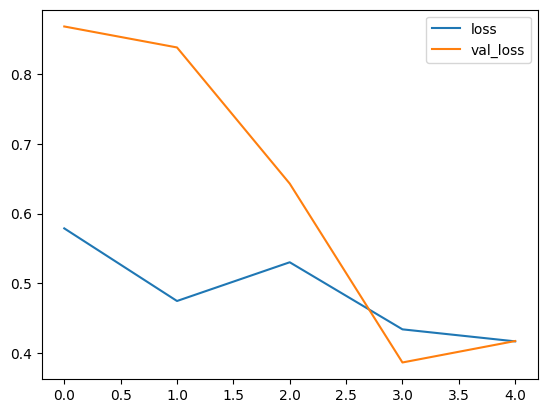

In [13]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

## Evaluation

W0000 00:00:1719395599.957458      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719395620.285671      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


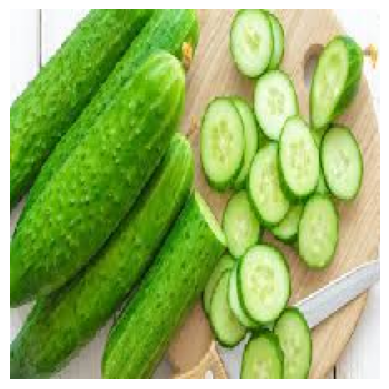

Prediction for custom image: O


In [14]:
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Assuming your image dimensions
IMG_DIM = (224, 224)

# Read in all O and R test images file paths. Shuffle and select 50 random test images.
test_files_O = glob.glob('/kaggle/input/waste-classification-data/DATASET/TEST/O/*.jpg')  # Adjust file extension as per your image format
test_files_R = glob.glob('/kaggle/input/waste-classification-data/DATASET/TEST/R/*.jpg')  # Adjust file extension as per your image format
test_files = test_files_O + test_files_R
test_files = shuffle(test_files)[:50]  # Shuffle and select 50 random images

# Extract images and labels
test_imgs = []
test_labels = []

for img in test_files:
    # Load and resize image
    img_array = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM))
    test_imgs.append(img_array)
    
    # Extract label from file path
    label = img.split('/')[-1].split('.')[0].strip()  # Extract label from file name
    test_labels.append(label)

# Convert lists to numpy arrays
test_imgs = np.array(test_imgs)
test_labels = np.array(test_labels)

# Standardize
test_imgs_scaled = test_imgs.astype('float32') / 255.0

# Define functions for label conversion
def class2num(label):
    return 0 if label == 'O' else 1

def num2class(num):
    return 'O' if num < 0.5 else 'R'

# Convert labels to numerical format for model training
test_labels_enc = np.array([class2num(label) for label in test_labels])

# Predict using the feature extraction model
predictions_model_history = model.predict(test_imgs_scaled, verbose=0)

# Convert predictions from probabilities to class labels
predictions_model_labels = np.array([num2class(pred) for pred in predictions_model_history])

# Example of predicting on a single custom image
custom_im = test_imgs_scaled[2]  # Assuming index 2 is a valid index in your test set

plt.imshow(custom_im)
plt.axis('off')
plt.show()

# Reshape and predict with the model
custom_im = custom_im.reshape((1, IMG_DIM[0], IMG_DIM[1], 3))  # Reshape to match model input shape
prediction_custom_im = model.predict(custom_im, verbose=0)
print(f"Prediction for custom image: {num2class(prediction_custom_im[0][0])}")

# Key Findings

- The training process shows consistent improvement across epochs, with the model achieving an accuracy of approximately 82% and reducing the loss from 0.63 to 0.34 by the end of 5 epochs. Validation accuracy also improved steadily, reaching 86.6% from an initial 77.7%, while validation loss decreased from 0.94 to 0.43, indicating effective learning and generalization.
- Training times vary, likely influenced by factors such as batch size, data loading efficiency, and hardware capabilities. These variations should be considered when optimizing training speed and resource usage.


# Next Steps

- Fine-tune Hyperparameters: Different learning rates can optimize convergence speed and final accuracy. Adjusting the batch size may also help balance training stability and memory usage.
- Modifying dropout rates, currently set at 0.5, to enhance generalization without compromising training accuracy. 
- Model Architecture: Adding or reducing layers, varying the number of neurons, or reordering layers to improve validation accuracy and convergence speed.